```
Created on April 19, 2019
将来的なNature Index予測を行う

Nature Indexの定義

ACはArticle Countの略で，論文ごとに全ての著者が所属する機関ごとに１ポイントを付与するものである．
FCはFractional Countの略で，論文ごとに全著者の中で特定の機関に所属する著者の割合をポイントとして付与するものである．
AC/FCはACをFCで割ったもので，この値が大きいほどその研究機関の多様性の高さを示している．

@author: ochi
```

In [1]:
import collections as cl
import codecs
import sys

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import os
import shutil
import csv
import random
import numpy as np
import sklearn.linear_model as slm
import sklearn.metrics as smt
import sklearn.metrics.pairwise as smp
import sklearn.neighbors as sn
import scipy.stats as ss
import seaborn as sns

In [2]:
def runAll():
#    cvs = [i for i in range(0,5,1)]
    cvs = [0]
#    iters = ["1000000","100000","10000","1000","100","10","1"]
    iters = ["10000"]
#    orders = ["1","2","joint"]
    orders = ["2"]
#    rhos = ["0.001","0.005","0.01","0.05","0.1","0.2","0.3","0.4","0.5"]
    rhos = ["0.2"]
    for cv in cvs:
        for order in orders:
            for itr in iters:
                for rho in rhos:
                    print("order:%s,iter:%s,rho:%s"%(order,itr,rho))
                    run(cv,order,itr,rho)
    return

In [3]:
def readSelectedAuthorsFile(filepath,delimiter=','):
    authors = []
    with open(filepath, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            aid = row[0]
            authors.append(aid)

    return authors

In [4]:
def readLabeledFile(afile, delimiter=','):
    labelDic = {}
    with open(afile, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            aid = row[0]
            label = row[1]
            labelDic[aid] = label

    return labelDic

In [5]:
def readVectorFilesJoint(vec_files, delimiter=' '):
    vecDics = []
    set_nodes = set([])
    for vec_file in vec_files:
        vecDic = readVectorFile(vec_file)
        vecDics.append(vecDic)
        if len(set_nodes) == 0:
            set_nodes = set(vecDic.keys())
        else:
            set_nodes &= set(vecDic.keys())

    m_vecDic = {}
    for node in list(set_nodes):
        new_vec = []
        for vecDic in vecDics:
            vec = vecDic[node]
            new_vec = np.append(new_vec,vec)

        m_vecDic[node] = new_vec

    return m_vecDic


In [6]:
def readVectorFile(vec_file, delimiter=' '):
    vecDic = {}
    with open(vec_file, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            if i == 0:
                # header line
                continue
            else:
                node = row[0]
                vec = np.array(row[1:-1],dtype=np.float)
                vecDic[node] = vec
            pass
    return vecDic

In [7]:
def makeMTXData(labelDic,vecDic,selected_authors,ref_aids=[]):
    xs = []
    ys = []
    vec_keys = set(vecDic.keys())
   
    selected_aids = []
    if len(ref_aids) == 0:
        aids = list(set(vecDic.keys())&set(labelDic.keys()))
    else:
        aids = ref_aids

    for i, aid in enumerate(aids):
        if aid not in vec_keys:
            continue

        selected_aids.append(aid)

        au_vec = vecDic[aid]
        distances = []
        label = labelDic[aid]
        for t_id in selected_authors:
            t_vec = vecDic[t_id]
#            distance = smp.cosine_distances([au_vec],[t_vec])[0,0]
            distance = smp.cosine_similarity([au_vec],[t_vec])[0,0]
            distances.append(distance)

#        a_x = distances
        # 近い順に並べてみる
        distances = sorted(distances, key=lambda x:-x)
        distances.append(float(label)) #特徴量に訓練させるラベルをまさかの追加
        a_x = distances
#        a_x = au_vec
        xs.append(a_x)
        y = int(labelDic[aid])
        ys.append(y)

    print("cos sim sorted")
    print(set(ys))
    y = np.array(ys, dtype=np.int).reshape((len(ys),1))
    print(y.shape)
    x = np.array(xs, dtype=np.float)
    print(x.shape)
    return x, y, selected_aids

In [8]:
def drawPRCMulti(yDic,probDic):

    num_c = 24
    linestyles = ['-','--','-.',':']
    palette = sns.color_palette("colorblind",num_c)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    lw = 2

    for i, name in enumerate(probDic.keys()):
#        print(name)
        probs = probDic[name]
        y     = yDic[name]
#        print(y)
#        print(set(probs))
#        precision, recall, thresholds = smt.precision_recall_curve(y,probs)
#        ax.step(recall, precision, color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

        if len(set(probs)) > 2:
            precision, recall, thresholds = smt.precision_recall_curve(y,probs)
            ax.step(recall, precision, color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])
        else:
            precision = smt.precision_score(y,probs)
            recall    = smt.recall_score(y,probs)
            ax.step(recall, precision, 'x', color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

        print(name)
        print("precision")
        print(precision)
        print("recall")
        print(recall)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall Rate')
    ax.set_ylabel('Precision Rate')
    ax.set_title('h-index Prediction Precision-Recall Results')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04,1.0))

#    plt.show()
    fig.savefig("natureindex_acfc_prediction_precision_recall_curve_many_results.pdf", dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')
#    fig.clf()
#    plt.close()

    return

In [9]:
def printPRF(yDic,probDic,pths=[i/100.0 for i in range(100)]):
    for pth in pths:
        for label in probDic.keys():
            plabels = []
            for prob in probDic[label]:
                if prob >= pth:
                    plabels.append(1)
                else:
                    plabels.append(0)

            (precision, recall, fscore, support) = smt.precision_recall_fscore_support(yDic[label], plabels, average="binary")
            print("pth=%.2f,method=%s,%f,%f,%f"%(pth,label,precision,recall,fscore))

    return

In [28]:
def drawROCMulti(yDic,probDic):
    num_c = 24
    linestyles = ['-','--','-.',':']
    palette = sns.color_palette("colorblind",num_c)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    lw = 2

    for i, name in enumerate(probDic.keys()):
        print(name)
        probs = probDic[name]
        y     = yDic[name]
        
        if len(set(probs)) > 2:
            fpr, tpr, thresholds = smt.roc_curve(y, probs)
            auc = smt.auc(fpr, tpr)
            ax.step(fpr, tpr, color=palette[i%num_c], alpha=0.8, where='post', label="%s:%.3f"%(name,auc), lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Results')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04,1.0))

    fig.savefig("natureindex_acfc_roc_curve_many_results.pdf", dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')
#    fig.clf()
#    plt.close()

    return

In [11]:
cv=0
order='1'
#itr='1'
#rho='0.1'
itr='3000'
rho='0.05'
th="0.200000"

In [12]:
#mode = "ac"
#mode = "fc"
mode = "acfc"

train_file   = "../../scopus_xml_scraper/csv01/top%sornot_natureindex_%s2013.csv"%(th,mode)
test_file    = "../../scopus_xml_scraper/csv01/top%sornot_natureindex_%s2016.csv"%(th,mode)
compare_results_file    = "../../scopus_xml_scraper/csv01/top%sornot_natureindex_%s2013.csv"%(th,mode)

#selectedauthors_file = "../../scopus_xml_scraper/csv01/select1institutions_natureindex_%s2009.csv"%(mode)
#selectedauthors_file = "../../scopus_xml_scraper/csv01/select10institutions_natureindex_%s2009.csv"%(mode)
selectedauthors_file = "../../scopus_xml_scraper/csv01/select100institutions_natureindex_%s2009.csv"%(mode)
#selectedauthors_file = "../../scopus_xml_scraper/csv01/select1000institutions_natureindex_%s2009.csv"%(mode)
#selectedauthors_file = "../../scopus_xml_scraper/csv01/select10000institutions_natureindex_%s2009.csv"%(mode)

if order == "joint":
    vectorfileDic = {
        "non_2009":[ "../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2009.txt"%("1",itr,rho),
                     "../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2009.txt"%("2",itr,rho),
                    ],
        "non_2013":[ "../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2013.txt"%("1",itr,rho),
                     "../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2013.txt"%("2",itr,rho),
                    ]
    }
else:
    vectorfileDic = {
#        "non_2009":"../res01sample_linkprd_new/non_all_vec_%s_%sst_%s_%s_wo_norm_until2009.txt"%(cv,order,itr,rho),
#        "non_2013":"../res01sample_linkprd_new/non_all_vec_%s_%sst_%s_%s_wo_norm_until2013.txt"%(cv,order,itr,rho),
#        "pre_2009":"../res01sample_linkprd_new/pre_all_vec_%s_%sst_%s_%s_wo_norm_until2009.txt"%(cv,order,itr,rho),
#        "pre_2013":"../res01sample_linkprd_new/pre_all_vec_%s_%sst_%s_%s_wo_norm_until2013.txt"%(cv,order,itr,rho),
#        "non_2009":"../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2009.txt"%(order,itr,rho),
#        "non_2013":"../res01citation/non_all_vec_%sst_%s_%s_wo_norm_until2013.txt"%(order,itr,rho),
    "non_2009":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2009.txt"%(cv,order,itr,rho),
    "non_2013":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2013.txt"%(cv,order,itr,rho),
    }


In [13]:
selected_authors = readSelectedAuthorsFile(selectedauthors_file)
train_labelDic = readLabeledFile(train_file)
test_labelDic  = readLabeledFile(test_file)
compare_labelDic = readLabeledFile(compare_results_file)


In [14]:
# print "Start: %s"%(a_mode)
if order == "joint":
    train_vec_files = vectorfileDic["non_2009"]
    train_vecDic = readVectorFilesJoint(train_vec_files)
else:
    train_vec_file = vectorfileDic["non_2009"]
#    train_vec_file = vectorfileDic["pre_2009"]
    train_vecDic = readVectorFile(train_vec_file)

print("complete getting train vectors")


complete getting train vectors


In [15]:
if order == "joint":
    test_vec_files = vectorfileDic["non_2013"]
    test_vecDic = readVectorFilesJoint(test_vec_files)
else:
    test_vec_file = vectorfileDic["non_2013"]
#    test_vec_file = vectorfileDic["pre_2013"]
    test_vecDic = readVectorFile(test_vec_file)

print("complete getting test vectors")

complete getting test vectors


In [16]:
train_aids = list(set(train_vecDic.keys())&set(train_labelDic.keys()))
test_aids  = list(set(test_vecDic.keys()) & set(test_labelDic.keys()) & set(compare_labelDic.keys()))
print(len(selected_authors))
selected_authors = list(set(train_aids)&set(test_aids)&set(selected_authors))
print(len(selected_authors))

200
87


In [17]:
train_x, train_y, train_aids =  makeMTXData(train_labelDic,train_vecDic,selected_authors,train_aids)
print("complete making train_xy")


cos sim sorted
{0, 1}
(1223, 1)
(1223, 88)
complete making train_xy


In [18]:
def getCompareResults(aids,compare_results_file):
    compare_labelDic = readLabeledFile(compare_results_file)
    test_compare_res = []
    for aid in aids:
        label = int(compare_labelDic[aid])
#        if label == 0:
#            label = -0.1
#        elif label == 1:
#            label = 1.1
        test_compare_res.append(label)

    return test_compare_res

In [19]:
test_compare_res = getCompareResults(test_aids, compare_results_file)
comp_labelDic = {}
for i,aid in enumerate(test_aids):
    comp_labelDic[aid] = test_compare_res[i]
    
test_compare_res1 = []
for res in test_compare_res:
    if res == 0:
        n_res = 0.25
    else:
        n_res = 0.75
    n_res += (random.random()-0.5)/2.0
    test_compare_res1.append(n_res)


In [20]:
test_x,  compare_y,  test_aids  =  makeMTXData(compare_labelDic,test_vecDic,selected_authors,test_aids)

tys = []
for aid in test_aids:
    l = test_labelDic[aid]
    tys.append(l)
    
test_y = np.array(tys, dtype=np.int).reshape((len(tys),1))


print("complete making test_xy")


cos sim sorted
{0, 1}
(635, 1)
(635, 88)
complete making test_xy


In [21]:
model = slm.LogisticRegression(penalty='l2',tol=1e-6,C=1.0,warm_start=True)
model.fit(train_x, train_y)
print("complete lr model fit")
test_probs = model.predict_proba(test_x)[:,1]
#print(test_probs)
#print(test_y)
for i, p in enumerate(test_probs):
    if test_y[i][0] == 1:
        print("%s,prob:%f,y:%d"%(test_aids[i],p,test_y[i][0]))

print("complete lr model predict")

complete lr model fit
60003269,prob:0.972349,y:1
60015682,prob:0.973390,y:1
60027165,prob:0.012998,y:1
60027272,prob:0.971650,y:1
60103006,prob:0.010180,y:1
60006221,prob:0.974320,y:1
60005398,prob:0.969637,y:1
60006288,prob:0.014076,y:1
60025709,prob:0.976111,y:1
60030840,prob:0.966338,y:1
60030743,prob:0.977139,y:1
60024322,prob:0.013792,y:1
60025641,prob:0.974793,y:1
60014264,prob:0.011961,y:1
60102151,prob:0.973013,y:1
60013409,prob:0.013570,y:1
60012614,prob:0.971842,y:1
60025590,prob:0.973755,y:1
60018205,prob:0.015450,y:1
60010261,prob:0.973210,y:1
60018308,prob:0.014890,y:1
60005286,prob:0.013338,y:1
60028717,prob:0.975661,y:1
60011447,prob:0.978687,y:1
60007278,prob:0.012826,y:1
60000762,prob:0.971978,y:1
60027762,prob:0.013346,y:1
60015986,prob:0.013412,y:1
60068815,prob:0.013231,y:1
60008293,prob:0.012126,y:1
60022109,prob:0.012982,y:1
60023020,prob:0.012458,y:1
60003915,prob:0.973955,y:1
60031419,prob:0.012982,y:1
60104544,prob:0.013820,y:1
60025960,prob:0.975561,y:1
600132

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
def getCompareResults(aids,compare_results_file):
    compare_labelDic = readLabeledFile(compare_results_file)
    test_compare_res = []
    for aid in aids:
        label = int(compare_labelDic[aid])
#        if label == 0:
#            label = -0.1
#        elif label == 1:
#            label = 1.1
        test_compare_res.append(label)

    return test_compare_res

In [30]:
test_probDic={}
test_yDic={}
test_probDic["non_2013"] = test_probs
#test_probDic["pre_2013"] = test_probs
test_probDic["ni_acfc2013"] = [float(ele) for ele in test_compare_res1]
test_yDic["non_2013"]    = test_y
#test_yDic["pre_2013"]    = test_y
test_yDic["ni_acfc2013"]    = test_y
#print "model.coef_"
#print model.coef_


In [31]:
printPRF(test_yDic,test_probDic)


pth=0.00,method=non_2013,0.291339,1.000000,0.451220
pth=0.00,method=ni_acfc2013,0.291339,1.000000,0.451220
pth=0.01,method=non_2013,0.290221,0.994595,0.449328
pth=0.01,method=ni_acfc2013,0.292063,0.994595,0.451534
pth=0.02,method=non_2013,0.410000,0.443243,0.425974
pth=0.02,method=ni_acfc2013,0.293076,0.983784,0.451613
pth=0.03,method=non_2013,0.410000,0.443243,0.425974
pth=0.03,method=ni_acfc2013,0.291874,0.951351,0.446701
pth=0.04,method=non_2013,0.410000,0.443243,0.425974
pth=0.04,method=ni_acfc2013,0.294314,0.951351,0.449553
pth=0.05,method=non_2013,0.410000,0.443243,0.425974
pth=0.05,method=ni_acfc2013,0.295918,0.940541,0.450194
pth=0.06,method=non_2013,0.410000,0.443243,0.425974
pth=0.06,method=ni_acfc2013,0.295533,0.929730,0.448501
pth=0.07,method=non_2013,0.410000,0.443243,0.425974
pth=0.07,method=ni_acfc2013,0.295652,0.918919,0.447368
pth=0.08,method=non_2013,0.410000,0.443243,0.425974
pth=0.08,method=ni_acfc2013,0.295053,0.902703,0.444740
pth=0.09,method=non_2013,0.410000,0.4

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
print(test_yDic.keys())
print(test_probDic.keys())

dict_keys(['non_2013', 'ni_acfc2013'])
dict_keys(['non_2013', 'ni_acfc2013'])


non_2013
precision
[ 0.29133858  0.29022082  0.28909953  0.28955696  0.29001585  0.29047619
  0.290938    0.29140127  0.29186603  0.29073482  0.2912      0.29166667
  0.29213483  0.2926045   0.29307568  0.29193548  0.29240711  0.29288026
  0.29335494  0.29383117  0.29430894  0.29478827  0.29526917  0.29575163
  0.29623568  0.29672131  0.29720854  0.29769737  0.29818781  0.29867987
  0.29917355  0.29966887  0.30016584  0.29900332  0.29950083  0.3
  0.29883139  0.2993311   0.29815745  0.29865772  0.29747899  0.2979798
  0.29848229  0.2972973   0.29780034  0.29661017  0.29711375  0.29761905
  0.29642249  0.29692833  0.2974359   0.29794521  0.29845626  0.29896907
  0.29948365  0.3         0.30051813  0.30103806  0.30155979  0.30208333
  0.3026087   0.30313589  0.30366492  0.3041958   0.30472855  0.30526316
  0.30579965  0.30633803  0.30687831  0.30742049  0.3079646   0.30851064
  0.30905861  0.30960854  0.31016043  0.31071429  0.31127013  0.31182796
  0.31238779  0.31294964  0.31351351  0.

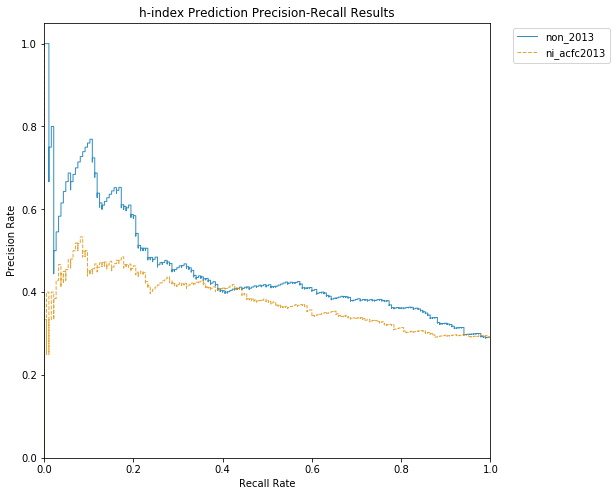

In [33]:
drawPRCMulti(test_yDic,test_probDic)

non_2013
ni_acfc2013


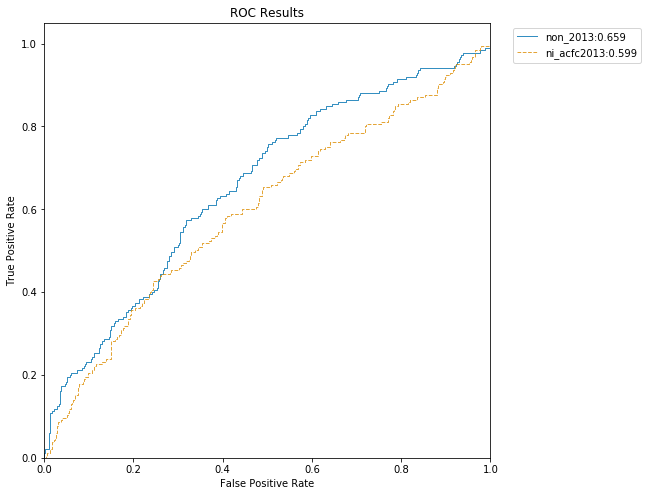

In [34]:
drawROCMulti(test_yDic,test_probDic)